In [1]:
import numpy as np
import torch

from models.positional_encoding import (
    AlibiPositionalBias, T5RelativePositionBias, RotaryPositionalEmbeddings, AbsolutePositionalEmbedding, ScaledSinusoidalEmbedding,
    CoPE)
import seaborn as sns
import matplotlib.pyplot as plt

## (T5) Relative Position Bias

Notes:
- given `(qseqlen, kseqlen)`, returns a tensor of shape `(heads, qseqlen, kseqlen)` of biases to be added to the attention scores
- if `causal=True`, `bias[h, i, j] = 0` for `j > i` (still need causal mask)
- the attention bias parameters learned of shape `(num_buckets, num_heads)`. A bias is learned for each bucket and each head.
- if `num_buckets = max_distance`, each bucket corresponds to a position, and bias is added up to relative position. For relative positions larger than `max_distance`, they all receive the same bias
- if `max_distance > num_buckets`, multiple positions can receive the same bias. First half of buckets (i.e., smaller relative distances) correspond to a single position, and the second half map on to logarithmically larger bins.

In [2]:
n_heads = 4
d_head = 32
sequence_length = 8
context_seq_length = 8
bsz = 1

# Create an instance of RelativePositionBias
relative_position_bias = T5RelativePositionBias(scale=d_head**0.5, causal=True, num_buckets=10, max_distance=20, heads=n_heads)

x, context = torch.randn(bsz, sequence_length, n_heads), torch.randn(bsz, context_seq_length, 64)

# Generate a relative position bias for a sequence length of 10
sequence_length = 10
attn_bias = relative_position_bias(x.shape[-2], context.shape[-2])

In [3]:
relative_position_bias.causal

True

In [4]:
relative_position_bias.relative_attention_bias

Embedding(10, 4)

In [5]:
import einx
from einops import rearrange

# reimplemnt forward function to include verbose output of intermediate steps
def forward(self, i, j):
        device = self.device
        q_pos = torch.arange(j - i, j, dtype=torch.long, device=device)
        k_pos = torch.arange(j, dtype=torch.long, device=device)
        rel_pos = einx.subtract("j, i -> i j", k_pos, q_pos)
        print('relative positions')
        print(rel_pos)
        rp_bucket = self._relative_position_bucket(
            rel_pos,
            causal=self.causal,
            num_buckets=self.num_buckets,
            max_distance=self.max_distance,
        )
        print()
        print('relative position bucket')
        print(rp_bucket)

        values = self.relative_attention_bias(rp_bucket)

        bias = rearrange(values, "i j h -> h i j")
        print('bias')
        print(bias)
        return bias * self.scale

In [6]:
forward(relative_position_bias, 20, 20)

relative positions
tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19],
        [ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
          13,  14,  15,  16,  17,  18],
        [ -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
          12,  13,  14,  15,  16,  17],
        [ -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
          11,  12,  13,  14,  15,  16],
        [ -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
          10,  11,  12,  13,  14,  15],
        [ -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,
           9,  10,  11,  12,  13,  14],
        [ -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,
           8,   9,  10,  11,  12,  13],
        [ -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,
           7,   8,   9,  10,  11,  12],
        [ -8,  -7,  -6,  -5, 

tensor([[[  2.7116,   2.7116,   2.7116,  ...,   2.7116,   2.7116,   2.7116],
         [ -4.1823,   2.7116,   2.7116,  ...,   2.7116,   2.7116,   2.7116],
         [ -0.2868,  -4.1823,   2.7116,  ...,   2.7116,   2.7116,   2.7116],
         ...,
         [ -5.1691,  -5.1691,   1.1842,  ...,   2.7116,   2.7116,   2.7116],
         [ -5.1691,  -5.1691,  -5.1691,  ...,  -4.1823,   2.7116,   2.7116],
         [ -5.1691,  -5.1691,  -5.1691,  ...,  -0.2868,  -4.1823,   2.7116]],

        [[ -0.6187,  -0.6187,  -0.6187,  ...,  -0.6187,  -0.6187,  -0.6187],
         [  5.5817,  -0.6187,  -0.6187,  ...,  -0.6187,  -0.6187,  -0.6187],
         [-12.9784,   5.5817,  -0.6187,  ...,  -0.6187,  -0.6187,  -0.6187],
         ...,
         [ -9.7470,  -9.7470,  -0.7586,  ...,  -0.6187,  -0.6187,  -0.6187],
         [ -9.7470,  -9.7470,  -9.7470,  ...,   5.5817,  -0.6187,  -0.6187],
         [ -9.7470,  -9.7470,  -9.7470,  ..., -12.9784,   5.5817,  -0.6187]],

        [[ -8.1739,  -8.1739,  -8.1739,  ...

## Alibi Position Bias

Notes:
- quite simple: for head `h`, add bias to position `[i,j]` in the attention scores that is equal to ` - slopes[h] * abs(i - j)`, where `slopes[h] = (1/4)**h` by default.

In [7]:
# Create an instance of AlibiPositionalBias
alibi_positional_bias = AlibiPositionalBias(heads=n_heads)

# Generate an attention bias for the given sequence length
alibi_attn_bias = alibi_positional_bias(50, 50)

# Print the generated attention bias
print(alibi_attn_bias[0])

tensor([[  0.0000,  -0.2500,  -0.5000,  ..., -11.7500, -12.0000, -12.2500],
        [ -0.2500,   0.0000,  -0.2500,  ..., -11.5000, -11.7500, -12.0000],
        [ -0.5000,  -0.2500,   0.0000,  ..., -11.2500, -11.5000, -11.7500],
        ...,
        [-11.7500, -11.5000, -11.2500,  ...,   0.0000,  -0.2500,  -0.5000],
        [-12.0000, -11.7500, -11.5000,  ...,  -0.2500,   0.0000,  -0.2500],
        [-12.2500, -12.0000, -11.7500,  ...,  -0.5000,  -0.2500,   0.0000]])


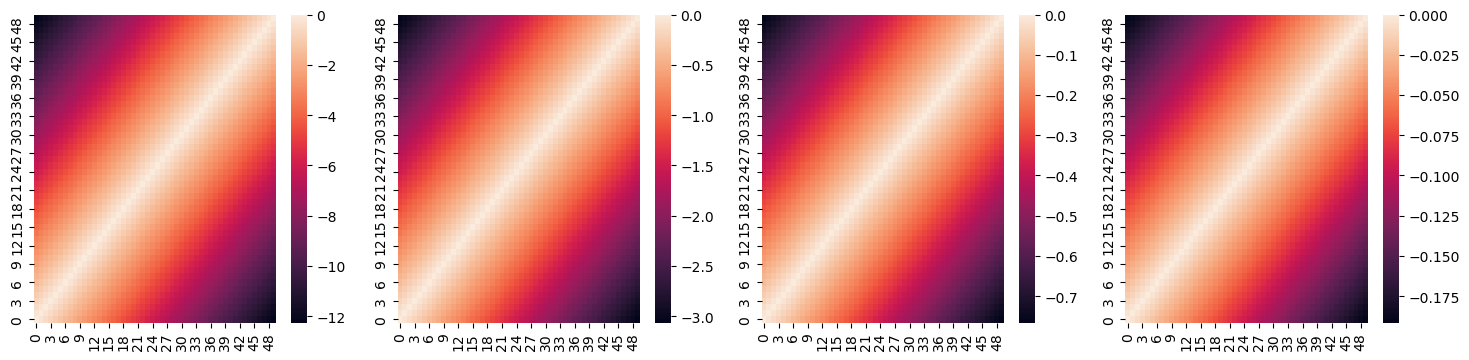

In [8]:
fig, axs = plt.subplots(ncols=n_heads, figsize=(18, 4))
for h in range(n_heads):
    sns.heatmap(alibi_attn_bias[h].detach().numpy(), ax=axs[h])
    axs[h].invert_yaxis()

In [9]:
alibi_positional_bias.slopes

tensor([[[0.2500]],

        [[0.0625]],

        [[0.0156]],

        [[0.0039]]])

## RoPE

Notes:
- takes `queries, keys` as input, tensors of shape `[bsz, seq_len, n_heads, head_dim]` and rotates them proportional to position such that relative rotation is equal to relative position.

torch.Size([1, 128, 1, 512])


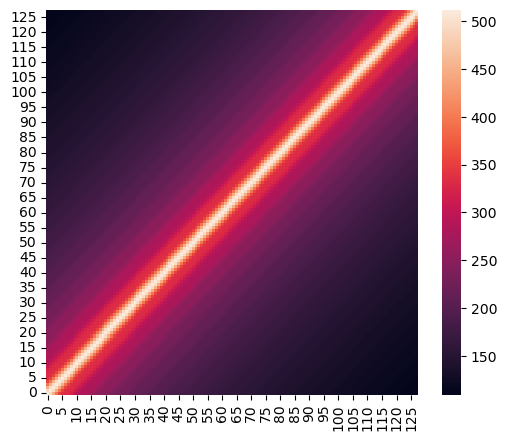

In [10]:
rope = RotaryPositionalEmbeddings(dim=512, max_seq_len=512, base=1000)

x = torch.ones((1, 128, 1, 512))
coped = rope(x) # shape: (bsz, seq_len, n_heads, dim_head)
print(coped.shape)

roped_sim = torch.matmul(coped[0,:, 0], coped[0,:,0].T).cpu().detach().numpy()
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(roped_sim, ax=ax)
ax.invert_yaxis()

## CoPE

Notes:
- a generalization of relative positional embeddings where the "counting" of whether each token should count in the positional distance is a learned function. This can in principle enable attention to focus on paragraphs or sections by their position (e.g., by only counting sentence separator tokens).
- In Relative Position Bias, you have $p_{ij} \propto (i - j)$ as a relative position bias. In CoPE, $p_{ij}$ is computed as $p_{ij} = \sum_{k=j}^{i} g_{ik}$, where $g_{ij} = \mathrm{Sigmoid}(q_i^{\intercal} k_j)$. Intuitively, $g_{ij} \in (0, 1)$ dictates to what degree this token should be counted when attending based on position. This is integrated via a (Shaw et al., 2018)-style RPE method as $a_{ij} = \mathrm{Softmax}(q_i^\intercal (k_j + e[p_{ij}]))$, where $p_{ij}$ is computed as above, and $e[\cdot]$ are learned relative positional embeddings (since $p_{ij}$ can take no-integer values, $e[\cdot]$ denotes an interpolation between the embeddings corresponding to the floor and ceiling).

Reference: https://arxiv.org/abs/2405.18719


torch.Size([1, 4, 128, 128])
torch.Size([1, 4, 128, 128])


<Axes: >

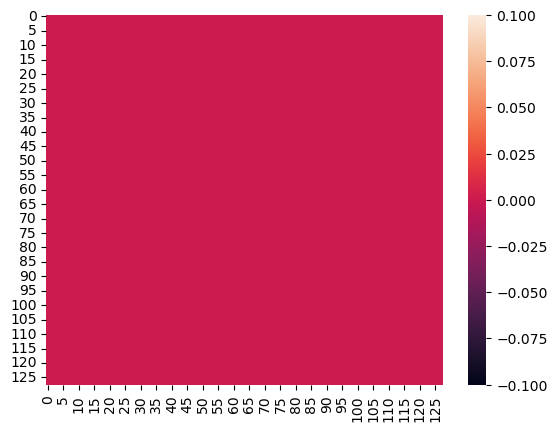

In [11]:
from models.positional_encoding import CoPE
d_model, sequence_length, n_heads = 512, 128, 4
cope = CoPE(dim=d_model, heads=n_heads, max_pos=128)

queries = torch.ones((1, n_heads, sequence_length, d_model))
keys = torch.randn((1, n_heads, sequence_length, d_model))

# NOTE: the expected input format for CoPE is different from RoPE (TODO: make consistent)
attn_logits = torch.matmul(queries, keys.transpose(-2, -1)) # shape: (bsz, n_heads, seq_len, seq_len)
print(attn_logits.shape)
coped = cope(queries, attn_logits) # shape: (bsz, seq_len, n_heads, dim_head)
print(coped.shape)

coped_sim = torch.matmul(coped[0,0,:], coped[0,0,:].T).cpu().detach().numpy()
sns.heatmap(coped_sim)

In [12]:
cope.pos_emb

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)

## Forgetting Transformer (Data-Dependent Alibi)

Notes:

Forgetting attention takes the form
$$o_i = \frac{\sum_{j=1}^{i} F_{ij} \exp(q_i^\intercal k_j) v_j}{F_{ij} \exp(q_i^\intercal k_j)} = \frac{\sum_{j=1}^{i} \exp(q_i^\intercal k_j + \log F_{ij}) v_j}{\exp(q_i^\intercal k_j + \log F_{ij})},$$
where $f_t = \sigma(w_f^\intercal x_t + b_f) \in (0, 1)$ is a forget gate, and $F_{ij} = \prod_{\ell = j+1}^{i} f_\ell$ is the cumulative product. This can be written in matrix form as
$$\bm{O} = \mathrm{Softmax}(\bm{Q} \bm{K}^\intercal + \log \bm{F}) \bm{V},$$

This can be interpreted as a "data-dependent AliBi", since when $w_f = 0$, the forget gate is $f_t = \exp(-b_f)$, so $\log F_{ij} = (i - j) b_f$.

Reference: https://openreview.net/pdf?id=q2Lnyegkr8

In [13]:
from models.positional_encoding import DataDependentAlibi

d_head, sequence_length, n_heads = 256, 128, 4
ddalibi = DataDependentAlibi(dim=d_model, heads=n_heads, causal=False)

x = torch.ones((1, sequence_length, d_model))

attn_biases = ddalibi(x) # shape: (bsz, seq_len, n_heads, dim_head)
print(attn_biases.shape)


torch.Size([1, 4, 128, 128])


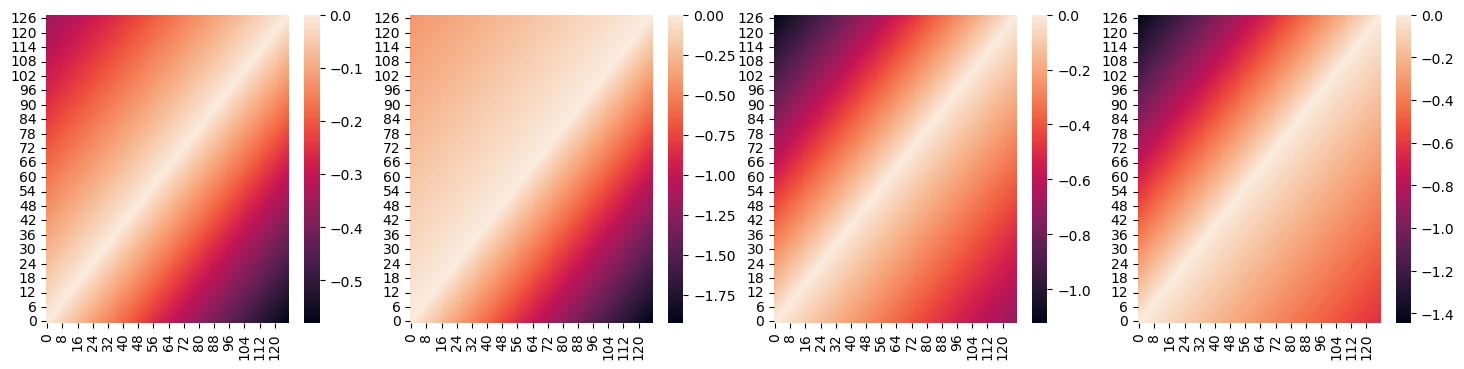

In [14]:
# attention biases at initialization
fig, axs = plt.subplots(ncols=n_heads, figsize=(18, 4))
for h in range(n_heads):
    sns.heatmap(attn_biases[0, h].detach().numpy(), ax=axs[h])
    axs[h].invert_yaxis()

## DynamicPositionBias

Notes:

- ...

In [15]:
from models.positional_encoding import DynamicPositionBias

d_head, sequence_length, n_heads = 256, 128, 4
dynamicposbias = DynamicPositionBias(dim=d_model, heads=n_heads, depth=1)

attn_biases = dynamicposbias(sequence_length, sequence_length) # shape: (bsz, seq_len, n_heads, dim_head)
print(attn_biases.shape)


torch.Size([4, 128, 128])


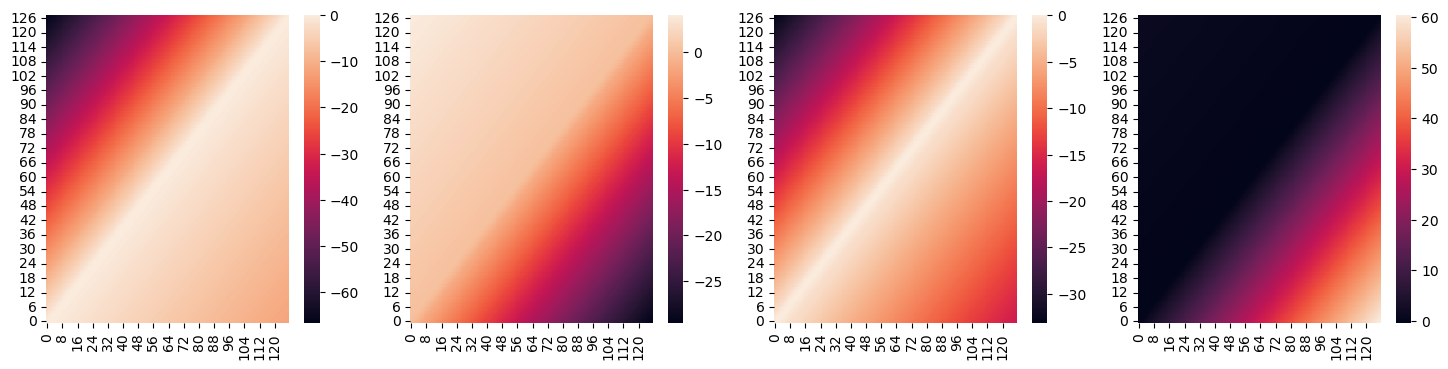

In [16]:
# attention biases at initialization
fig, axs = plt.subplots(ncols=n_heads, figsize=(18, 4))
for h in range(n_heads):
    sns.heatmap(attn_biases[h].detach().numpy(), ax=axs[h])
    axs[h].invert_yaxis()

## Learned Absolute Positional Embeddings

Notes:
- Simply adds learned embeddings for each positions

In [17]:
# Create an instance of AbsolutePositionalEmbedding
absolute_positional_embedding = AbsolutePositionalEmbedding(dim=64, max_seq_len=16)

# Generate embeddings for the given sequence length
x = torch.randn(1, 8, 64)
absolute_embeddings = absolute_positional_embedding(x)
x += absolute_embeddings

# Print the generated embeddings
print(absolute_embeddings.shape)
print(x.shape)

torch.Size([8, 64])
torch.Size([1, 8, 64])


## Sinusoidal Positional Embeddings

Notes:
- Absolute positional embeddings with a fixed value based on sines and cosines. Also includes an optional scale. Frequencies of sines and cosine are based on a default of `theta = 10_000`.

In [18]:
# Create an instance of AbsolutePositionalEmbedding
absolute_positional_embedding = ScaledSinusoidalEmbedding(dim=64)

# Generate embeddings for the given sequence length
x = torch.randn(1, 8, 64)
absolute_embeddings = absolute_positional_embedding(x)
x += absolute_embeddings

# Print the generated embeddings
print(absolute_embeddings.shape)
print(x.shape)

torch.Size([8, 64])
torch.Size([1, 8, 64])


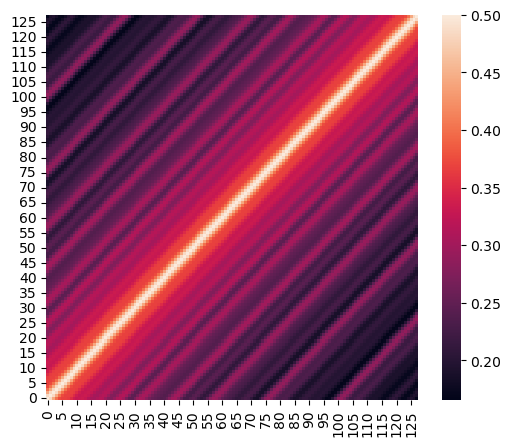

In [19]:
import seaborn as sns

x = torch.randn(1, 128, 64)
absolute_embeddings = absolute_positional_embedding(x)

pos_sim = torch.matmul(absolute_embeddings, absolute_embeddings.T).detach().cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(pos_sim, ax=ax)
ax.invert_yaxis()